In [34]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':1.5, 'capsize':3, 'capthick':1.5}


In [35]:
evs = []
data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
for subject, df in data.groupby('subject'):
    for session in pd.unique(df['session']):
        r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
        temp = r.load('all_events')
        evs.append(temp)
evs = pd.concat(evs)
evs = evs[evs.list != 0]
#word_evs[word_evs['item_num'] == 0].head()

In [36]:
import os
root = '/data/eeg/scalp/ltp/'
experiment = 'ltpRepFR'
with open(os.path.join(root, experiment, 'wordpool.txt'), "r") as f:
    wordpool = [w.strip().upper() for w in f.readlines()]
wordpool.pop(0)

item_num_df = pd.DataFrame({'item_name': wordpool}).reset_index()
item_num_df.rename(columns={'index': 'item_num'}, inplace=True)
new_evs = evs.merge(item_num_df, on='item_name', suffixes=('', '_new'))
test_evs = new_evs.query('type == ["WORD", "REC_WORD"] and item_num >= 0')
test_evs.query('item_num != item_num_new')
np.sort(test_evs.item_num_new.unique())
# word_evs = new_evs[new_evs.type=='WORD']
# word_evs = word_evs.loc[word_evs.repeats != -999]
# rec_evs = new_evs[new_evs.type=='REC_WORD']
# test_evs.item_num_new.nunique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [21]:
first_crp = []
for i, df in lol(word_evs.groupby(['subject', 'session'])):
    try:
#         df = df.loc[df.repeats == 3]
        df = df.drop_duplicates('item_num')
        positions = len(df.item_num.unique())
        df['serialpos'] = pd.Series(range(positions), index = df.index)
        first_crp.append(df)
    except:
        a, b, c = i
        print('Subject ' + a + ' session ' + str(b) + ' failed')
first_crp = pd.concat(first_crp)


In [22]:
# evs=first_crp.append(rec_evs)

# evs = evs[evs.list < 26]
# ffr = word_evs.append(rec_evs[rec_evs.list == 26])
# # ffr = ffr.append(rec_evs[rec_evs])
# ffr['list'] = pd.Series(26, ffr.index)
# test_ffr = ffr[(ffr.subject == 'LTP441') & (ffr.session == 9)]
# # ffr[ffr.type == "WORD"].groupby(['subject', 'session']).item_num.duplicated()
# test_ffr[test_ffr.type == 'WORD'].item_num.duplicated()
# test_ffr[(test_ffr.type == 'WORD') & (test_ffr.item_num ==140)]

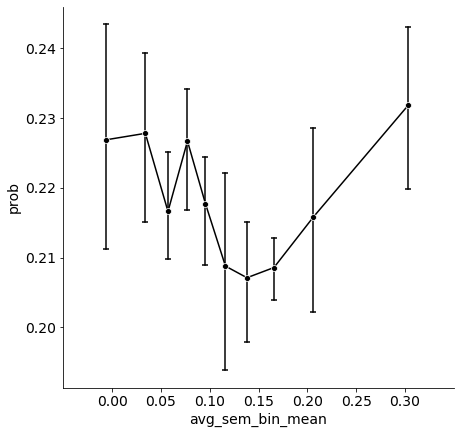

In [23]:
evs = first_crp.append(rec_evs)
sem_crp = []
n_bins = 10
sim_mat = pd.read_csv('similarity_matrix.csv', index_col = 0)
sem_crp = evs.groupby(['subject']).apply(lambda x: pb.pd_sem_crp(x, itemno_column='item_num_new', list_index=['subject', 'session', 'list'], sem_sims = sim_mat, n_bins=n_bins)).reset_index()

sem_crp.set_index('sem_bin', inplace = True)
sem_crp['avg_sem_bin_mean'] = sem_crp.groupby('sem_bin').sem_bin_mean.mean()
sem_crp.reset_index(inplace = True)
set_axes(xticks = np.arange(0,.31,.05), xlim = [-0.05, 0.35])
sns.lineplot(data = sem_crp, x = 'avg_sem_bin_mean', y = 'prob',err_style = 'bars', ci = 95, marker = 'o', color = 'black', err_kws=error_bars)

# display(sem_crp)

In [12]:
def sem_crp(dataframe, bins):
    sim_mat = pd.read_csv('similarity_matrix.csv', index_col = 0)
    full_sims = []
    for j in list(range(sim_mat.shape[0])):
        for k in sim_mat.iloc[j].tolist():
            full_sims.append(k)
    similarities = pd.Series(full_sims).value_counts()
    similarities = similarities[similarities < 5]
    sims = (similarities[similarities != 3] / 2).reset_index()
    sims = sims.rename(columns={0:'amt'})
    part_sims = []
    for row in sims.iterrows():
        a,b = row
        for i in range(int(b['amt'])):
            part_distances.append(b['index'])
    full_sims = pd.Series(part_distances)
    bin_series, bin_nos = pd.qcut(full_sims, q = bins, retbins = True)
    sims = sim_mat
    sem_crps = []
    for sub, sub_df in dataframe.groupby('subject'):
        sub_crps = []
        for sess, sess_df in sub_df.groupby('session'):
            sess_counts = []
            for l, df in sess_df.groupby('list'):
                word_evs = df[df.type == 'WORD']
                rec_evs = df[df.type=='REC_WORD']
                rec_evs.at[rec_evs.intrusion != 0, 'item_num'] = -999
                recs = rec_evs.item_num.unique()
                encs = word_evs.item_num.unique()
                pos_sims = np.zeros(len(bin_nos)-1)
                act_sims = []
                for outpos, item in enumerate(recs):
                    try:
                        encs = np.delete(encs, np.where(encs == item))
                        temp = np.zeros(len(bin_nos)-1)
                        for other in encs:
                            place, _ = np.histogram(sim_mat.iloc[item, other], bins = bin_nos)
                            place = np.where(place == 1)
                            temp[place] = 1
                        pos_sims+= temp
                        try: act_sims.append(sim_mat.iloc[item, recs[i+1]])
                        except: pass
                    except IndexError:
                        pass
                pos_sims = np.array(pos_sims)
                act_sims = np.array(act_sims)
                bin_act, _ = np.histogram(act_sims, bin_nos)
                temp = pd.DataFrame(data=bin_act, columns = ['act'])
                temp['pos'] = pos_sims
                sess_counts.append(temp)
            sess_counts = pd.concat(sess_counts).reset_index().groupby('index').sum()
            sess_counts['prop'] = sess_counts.act/sess_counts.pos
            sess_counts['subject'] = sub
            sess_counts['session'] = sess
            bin_centers = []
            for i, b in enumerate(bin_nos):
                try: bin_centers.append((b+bin_nos[i+1])/2)
                except: pass
            sess_counts['bin_centers'] = pd.Series(bin_centers)
            sub_crps.append(sess_counts)
        sub_crps = pd.concat(sub_crps)
        sem_crps.append(sub_crps.reset_index().groupby(['subject', 'index']).mean().drop(['session', 'act', 'pos'], 1).reset_index())
    sem_crps = pd.concat(sem_crps)
    sem_crps = sem_crps.rename(columns={'index':'bin'}).reset_index()
    return (sem_crps, bin_nos)       



In [13]:
# for i, val in enumerate(bin_nos):
#     try:
        
sem_crps, bin_nos = sem_crp(evs, 9)
# bin_nos

NameError: name 'part_distances' is not defined

NameError: name 'sem_crps' is not defined

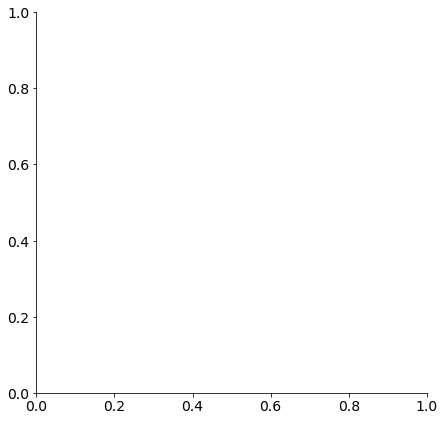

In [9]:
set_axes()
sns.lineplot(data = sem_crps, x = 'bin_centers', y = 'prop', color = 'black', marker = 'o', err_style = 'bars', err_kws=error_bars)